In [1]:
# https://stackoverflow.com/questions/43599018/is-there-a-way-to-get-matplotlib-path-contains-points-to-be-inclusive-of-boundar
#I do quite like this command in Jupiter notebook:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
#It makes things wider and not waste the space on your screen
import pandas as pd
import importlib
import csv,os
import numpy as np
import pandas as pd
import itertools
from uafgi import ioutil,shputil,greenland
import pyproj
import shapely
import copy
from uafgi import gicollections

#pd.set_option('display.max_rows', 30)

In [2]:
importlib.reload(gicollections)
importlib.reload(greenland)
map_wkt = "PROJCS[\"WGS 84 / NSIDC Sea Ice Polar Stereographic North\",GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AUTHORITY[\"EPSG\",\"4326\"]],PROJECTION[\"Polar_Stereographic\"],PARAMETER[\"latitude_of_origin\",70],PARAMETER[\"central_meridian\",-45],PARAMETER[\"false_easting\",0],PARAMETER[\"false_northing\",0],UNIT[\"metre\",1,AUTHORITY[\"EPSG\",\"9001\"]],AXIS[\"Easting\",SOUTH],AXIS[\"Northing\",SOUTH],AUTHORITY[\"EPSG\",\"3413\"]]"

# Master set of glaciers from which we will select
w21 = greenland.read_w21(map_wkt)
# Join by name to get location
bkm15 = greenland.read_bkm15(map_wkt)

/Users/eafischer2/spack/var/spack/environments/pismip6-catalina/.spack-env/view/lib/python3.7/site-packages/pandas/core/series.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [3]:
def select_glaciers(w21, w21_blackouts=None):
    """w21_blackouts:
        DataFrame with index matching w21, cols do not matter; rows we do NOT want to select.
    """
    glaciers = w21.df.copy()

    if w21_blackouts is not None:
        # Get the original w21.df's index onto the blackouts list
        blackouts_index= pd.merge(w21.df.reset_index(), w21_blackouts, how='inner', on='w21_key').set_index('index').index

        # Remove items we previously decided we DID NOT want to select
        glaciers = glaciers.drop(blackouts_index, axis=0)

    # Select glaciers with fjord width between 2km and 4km
    glaciers = glaciers[(glaciers['w21_mean_fjord_width'] >=2) & (glaciers['w21_mean_fjord_width'] <= 4)]

    # Categorize by different regions / glacier types
    dfg = glaciers.groupby(['w21_coast', 'w21_category'])

    # Select glacier with maximum mean discharge in each category
    # https://stackoverflow.com/questions/32459325/python-pandas-dataframe-select-row-by-max-value-in-group?noredirect=1&lq=1
    select = dfg.apply(lambda group: group.nlargest(1, columns='w21_mean_discharge')).reset_index(drop=True)
    return w21.replace(df=select)

In [35]:
importlib.reload(greenland)

# Set up glacers we DON'T want to select
w21_blackouts = pd.DataFrame({
    'w21_key' : [
#        ('Bowdoin Gl.', 'BOWDOIN'),
#        ('F. Graae Gl.', 'F_GRAAE'),
#        ('Vestfjord Gl.', 'VESTFJORD'),
    ]
})

select = select_glaciers(w21, w21_blackouts)

over = greenland.read_overrides('overrides.ods', 'troughs/shp/terminus_locations.shp', ['w21_key', 'bkm15_key'], 'w21_key', map_wkt)
#print(over[['bkm15_key', 'lat', 'lon']])

# Join with bkm15
match = greenland.match_allnames(select, bkm15)
select = match.left_join(overrides=over)
select.df[['w21_key','bkm15_key']]

,w21_key,bkm15_key
index,,
0,"(Vestfjord Gl., VESTFJORD)",GGN0275
1,"(F. Graae Gl., F_GRAAE)",GGN0394
2,"(Deception O Gl. CN, UNNAMED_DECEPTION_O_CN_CS)",NaN
3,"(Frederiksborg Gl., FREDERIKSBORG_GLETSCHER)",GGN0211
4,"(Perlerfiup Se., SERMEQ_SILARLEQ)",GGN0303
5,"(Sermeq Avannarleq, SERMEQ_AVANNARLEQ)",GGN0265
6,"(Kangilleq, CW_NONAME2)",GGN0295
7,"(Marie Sophie Gl., MARIE_SOPHIE_GLETSCHER)",GGN0701
8,"(Steensby Gl., STEENSBY_GLETSCHER)",GGN0693


In [36]:
importlib.reload(greenland)

select.df = greenland.override_cols(select.df, over, 'w21_key',
    [('bkm15_lat', 'lat', 'lat'),
     ('bkm15_lon', 'lon', 'lon'),
     ('bkm15_loc', 'loc', 'loc')])

# Divide rows into ones with and without 'loc' column
# Now we need to fill in sel1
sel0 = df[~df['loc'].isnull()]
sel1 = df[df['loc'].isnull()]

#print(sel1[['w21_key', 'bkm15_key', 'lat', 'lon']])
sel0


Index(['w21_popular_name', 'w21_greenlandic_name', 'w21_coast', 'w21_category',
       'w21_Qr', 'w21_Qf', 'w21_Qm', 'w21_Qs', 'w21_Qc_inferred', 'w21_qm',
       'w21_qf', 'w21_qc', 'w21_mean_depth', 'w21_min_depth',
       'w21_quality_str', 'w21_area_grounded_1992_2017',
       'w21_area_grounded_1992_1997', 'w21_area_grounded_1998_2007',
       'w21_area_grounded_2008_2017', 'w21_mean_fjord_width',
       'w21_length_grounded_1992_2017', 'w21_length_grounded_1992_1997',
       'w21_length_grounded_1998_2007', 'w21_length_grounded_2008_2017',
       'w21_ocean_model_sample_area', 'w21_mean_TF_1992-2017',
       'w21_mean_TF_1992-1997', 'w21_mean_TF_1998-2007',
       'w21_mean_TF_2008-2017', 'w21_subglacial_discharge_1992_2017',
       'w21_subglacial_discharge_1992_1997',
       'w21_subglacial_discharge_1998_2007',
       'w21_subglacial_discharge_2008_2017', 'w21_mean_xsection_area',
       'w21_mean_undercuttong_1992_2017', 'w21_mean_undercuttong_1992_1997',
       'w21_mean_und

,w21_popular_name,w21_greenlandic_name,w21_coast,w21_category,w21_Qr,w21_Qf,w21_Qm,w21_Qs,w21_Qc_inferred,w21_qm,...,bkm15_id,bkm15_new_greenl_name,bkm15_old_greenl_name,bkm15_foreign_name,bkm15_official_name,bkm15_alt,bkm15_allnames,lat,lon,loc
0,Vestfjord Gl.,,CE,CR,1.06,1.69,0.12,0.00,NaN,NaN,...,GGN0275,NaN,NaN,Vestfjord Gletsjer,Vestfjord Gletsjer,NaN,"(Vestfjord Gletsjer, nan, nan, Vestfjord Glets...",70.2942,-29.4703,POINT (577007.2829625887 -2076440.755251836)
1,F. Graae Gl.,,CE,DW,1.67,4.03,3.58,0.00,2.12,0.02,...,GGN0394,NaN,NaN,F. Graae Gletsjer,F. Graae Gletsjer,NaN,"(F. Graae Gletsjer, nan, nan, F. Graae Gletsje...",72.0833,-28.2333,POINT (564315.6860823556 -1873037.319925007)
2,Deception O Gl. CN,,CE,NC,5.41,15.46,NaN,0.02,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.3990,-33.3990,POINT (493481.5591488858 -2403841.698923002)
3,Frederiksborg Gl.,,CE,SC,0.39,-0.87,-0.01,0.00,NaN,0.10,...,GGN0211,NaN,NaN,Frederiksborg Gletsjer,Frederiksborg Gletsjer,NaN,"(Frederiksborg Gletsjer, nan, nan, Frederiksbo...",68.4557,-31.6620,POINT (544583.0479349882 -2296942.835866181)
4,Perlerfiup Se.,Perlerfiup Sermia,CW,DW,3.38,0.91,1.53,0.00,2.76,0.46,...,GGN0303,Perlerfiup Sermia,Perdlerfiup Sermia,NaN,Perlerfiup Sermia,NaN,"(Perlerfiup Sermia, Perlerfiup Sermia, Perdler...",70.9909,-50.9227,POINT (-214374.3459893014 -2066450.273916265)
5,Sermeq Avannarleq,Sermeq Avannarleq,CW,NC,3.32,1.95,NaN,0.00,NaN,NaN,...,GGN0265,Sermeq Avannarleq,Sermeq Avangnardleq,NaN,Sermeq Avannarleq,NaN,"(Sermeq Avannarleq, Sermeq Avannarleq, Sermeq ...",70.0853,-50.2468,POINT (-199207.1243908704 -2169285.139298873)
6,Kangilleq,Kangilleq,CW,SC,0.13,0.01,0.83,0.00,NaN,0.70,...,GGN0295,Kangilleq,Kangigdleq,NaN,Kangilleq,NaN,"(Kangilleq, Kangilleq, Kangigdleq, nan, nan)",70.7184,-50.6523,POINT (-207606.4484360412 -2097617.01825531)
7,Marie Sophie Gl.,,N,DW,1.04,-0.58,0.67,0.19,-0.40,0.12,...,GGN0701,NaN,NaN,Marie Sophie Gletsjer,Marie Sophie Gletsjer,NaN,"(Marie Sophie Gletsjer, nan, nan, Marie Sophie...",81.7833,-34.5000,POINT (162473.9110486274 -876630.7774416686)
8,Steensby Gl.,,N,FE,-0.71,0.69,0.52,0.00,NaN,0.04,...,GGN0693,NaN,NaN,Steensby Gletsjer,Steensby Gletsjer,NaN,"(Steensby Gletsjer, nan, nan, Steensby Gletsje...",81.3833,-54.0333,POINT (-146821.1647750149 -923518.1524328493)
9,Diebitsch Gl.,Arfalluarfiup Sermia,N,NC,1.61,0.65,NaN,0.00,NaN,NaN,...,GGN0658,Arfalluarfiup Sermia,Pitorâviup Sermia,Clements Markham Gletsjer,Arfalluarfiup Sermia,Pitoraaviup Sermia,"(Arfalluarfiup Sermia, Arfalluarfiup Sermia, P...",77.9475,-71.8501,POINT (-591787.5054794166 -1168999.088309967)


##### sel1[['w21_key', 'loc']]

In [38]:
importlib.reload(greenland)
fj = greenland.read_fj(map_wkt)
match = greenland.match_point_poly(select, 'loc', fj, 'fj_poly')
select = match.left_join(right_cols=['fj_poly'])
#match.left_join().df[['w21_key', 'lat', 'lon', 'fj_poly']]
select.df.columns
select.df

,w21_popular_name,w21_greenlandic_name,w21_coast,w21_category,w21_Qr,w21_Qf,w21_Qm,w21_Qs,w21_Qc_inferred,w21_qm,...,bkm15_new_greenl_name,bkm15_old_greenl_name,bkm15_foreign_name,bkm15_official_name,bkm15_alt,bkm15_allnames,lat,lon,loc,fj_poly
index,,,,,,,,,,,,,,,,,,,,,
0,Vestfjord Gl.,,CE,CR,1.06,1.69,0.12,0.00,NaN,NaN,...,NaN,NaN,Vestfjord Gletsjer,Vestfjord Gletsjer,NaN,"(Vestfjord Gletsjer, nan, nan, Vestfjord Glets...",70.2942,-29.4703,POINT (577007.2829625887 -2076440.755251836),POLYGON ((598469.6016746098 -2067935.494332621...
1,F. Graae Gl.,,CE,DW,1.67,4.03,3.58,0.00,2.12,0.02,...,NaN,NaN,F. Graae Gletsjer,F. Graae Gletsjer,NaN,"(F. Graae Gletsjer, nan, nan, F. Graae Gletsje...",72.0833,-28.2333,POINT (564315.6860823556 -1873037.319925007),POLYGON ((553232.1652885491 -1884096.042851279...
2,Deception O Gl. CN,,CE,NC,5.41,15.46,NaN,0.02,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-33.3990,-33.3990,POINT (493481.5591488858 -2403841.698923002),POLYGON ((498198.5120069756 -2395971.815185406...
3,Frederiksborg Gl.,,CE,SC,0.39,-0.87,-0.01,0.00,NaN,0.10,...,NaN,NaN,Frederiksborg Gletsjer,Frederiksborg Gletsjer,NaN,"(Frederiksborg Gletsjer, nan, nan, Frederiksbo...",68.4557,-31.6620,POINT (544583.0479349882 -2296942.835866181),POLYGON ((547444.9131506938 -2316717.685679635...
4,Perlerfiup Se.,Perlerfiup Sermia,CW,DW,3.38,0.91,1.53,0.00,2.76,0.46,...,Perlerfiup Sermia,Perdlerfiup Sermia,NaN,Perlerfiup Sermia,NaN,"(Perlerfiup Sermia, Perlerfiup Sermia, Perdler...",70.9909,-50.9227,POINT (-214374.3459893014 -2066450.273916265),POLYGON ((-216830.321290521 -2063046.486024775...
5,Sermeq Avannarleq,Sermeq Avannarleq,CW,NC,3.32,1.95,NaN,0.00,NaN,NaN,...,Sermeq Avannarleq,Sermeq Avangnardleq,NaN,Sermeq Avannarleq,NaN,"(Sermeq Avannarleq, Sermeq Avannarleq, Sermeq ...",70.0853,-50.2468,POINT (-199207.1243908704 -2169285.139298873),NaN
6,Kangilleq,Kangilleq,CW,SC,0.13,0.01,0.83,0.00,NaN,0.70,...,Kangilleq,Kangigdleq,NaN,Kangilleq,NaN,"(Kangilleq, Kangilleq, Kangigdleq, nan, nan)",70.7184,-50.6523,POINT (-207606.4484360412 -2097617.01825531),POLYGON ((-217681.8575036907 -2095200.78313045...
7,Marie Sophie Gl.,,N,DW,1.04,-0.58,0.67,0.19,-0.40,0.12,...,NaN,NaN,Marie Sophie Gletsjer,Marie Sophie Gletsjer,NaN,"(Marie Sophie Gletsjer, nan, nan, Marie Sophie...",81.7833,-34.5000,POINT (162473.9110486274 -876630.7774416686),POLYGON ((189251.1483580394 -868988.9774828344...
8,Steensby Gl.,,N,FE,-0.71,0.69,0.52,0.00,NaN,0.04,...,NaN,NaN,Steensby Gletsjer,Steensby Gletsjer,NaN,"(Steensby Gletsjer, nan, nan, Steensby Gletsje...",81.3833,-54.0333,POINT (-146821.1647750149 -923518.1524328493),POLYGON ((-146117.4111413819 -859828.007851304...


In [39]:
importlib.reload(greenland)
ns481 = greenland.read_ns481(map_wkt)
ns481.df.columns
#print(list(zip(ns481.df.ns481_key, ns481.df.ns481_poly)))

Index(['ns481_grid', 'ns481_poly', 'ns481_key'], dtype='object')

In [42]:
importlib.reload(greenland)
over = greenland.read_overrides('overrides.ods', 'troughs/shp/terminus_locations.shp', ['w21_key', 'bkm15_key'], 'w21_key', map_wkt)


print(len(select.df))
match = greenland.match_point_poly(select, 'loc', ns481, 'ns481_poly',
    left_cols=['fj_poly'], right_cols=['ns481_poly'])
match.df['fjord_grid_overlap'] = match.df.apply(
        lambda x: 0 if (type(x['ns481_poly'])==float or type(x['fj_poly']) == float)
        else x['ns481_poly'].intersection(x['fj_poly']).area / x['fj_poly'].area,
        axis=1)

#match.df = pd.merge(match.df, select.df, on='w21_key', how='left')
#match.df.sort_values(['w21_ix'])
match.df.sort_values(['w21_ix'])

sel = match.left_join(overrides=over[['w21_key', 'ns481_key']])
#print(sel.df.columns)
sel.df[['w21_key', 'ns481_key', 'ns481_grid']]

#match.df

#sel.df[['w21_key', 'ns481_key', 'ns481_grid']]
#sel.df[~sel.df['ns481_poly'].isna()][['w21_key', 'ns481_key', 'ns481_grid']]

24


,w21_key,ns481_key,ns481_grid
index,,,
0,"(Vestfjord Gl., VESTFJORD)",NaN,NaN
1,"(F. Graae Gl., F_GRAAE)",E71.75N,E71.75N
2,"(Deception O Gl. CN, UNNAMED_DECEPTION_O_CN_CS)",E67.55N,E67.55N
3,"(Frederiksborg Gl., FREDERIKSBORG_GLETSCHER)",NaN,NaN
4,"(Perlerfiup Se., SERMEQ_SILARLEQ)",W70.90N,W70.90N
5,"(Sermeq Avannarleq, SERMEQ_AVANNARLEQ)",W69.95N,W69.95N
6,"(Kangilleq, CW_NONAME2)",W70.90N,W70.90N
7,"(Marie Sophie Gl., MARIE_SOPHIE_GLETSCHER)",NaN,NaN
8,"(Steensby Gl., STEENSBY_GLETSCHER)",NaN,NaN


In [78]:
match.df['grid_fjord_over'] = match.df.apply(
    lambda x: 0 if (type(x['grid_poly'])==float or type(x['fjord']) == float) else x['grid_poly'].intersection(x['fjord']).area,
    axis=1).rename('overlap')


print(match.df.columns)
sel = match.left_join()
#match.df

24
Index(['w21_ix', 'ns481_ix', 'w21_key', 'ns481_key'], dtype='object')


,w21_ix,ns481_ix,w21_key,ns481_key
0,1,0,"(F. Graae Gl., F_GRAAE)",E71.75N
1,6,2,"(Kangilleq, CW_NONAME2)",W70.55N
2,14,6,"(Kong Oscar Gl., KONG_OSCAR_GLETSCHER)",W76.10N
3,16,6,"(Nordenskiold Gl. N, NORDENSKIOLD_GLESCHER_NW)",W76.10N
4,16,10,"(Nordenskiold Gl. N, NORDENSKIOLD_GLESCHER_NW)",W75.85N
5,18,13,"(Rimfaxe Gl., RIMFAXE)",E63.35N
6,20,15,"(Midgard Gl., MIDGARDGLETSCHER)",E66.60N
7,17,16,"(Upernavik Isstrom SS, UPERNAVIK_ISSTROM_SS)",W72.90N
8,18,18,"(Rimfaxe Gl., RIMFAXE)",E63.00N
9,19,22,"(Koge Bugt Gl. C, KOGE_BUGT_C)",E65.10N


In [21]:
# Join with m17
m17 = greenland.read_m17(map_wkt)
sel1x = select.replace(df=sel1)
xf = greenland.match_allnames(sel1x, m17).left_join()
print(xf.df.columns)

#match.df
#df[['w21_key', 'bkm15_key', 'lat', 'lon', 'loc']]

ValueError: 

In [ ]:
greenland.read_m17(map_wkt).df.columns

In [17]:
print(len(bkm15.df))
#bkm15.df[bkm15.df.bkm15_key == 'GGN0300']

285


Index(['grid', 'poly', 'wkt'], dtype='object')


Index(['ns481_grid', 'ns481_poly', 'ns481_key'], dtype='object')

In [185]:
import shapely
PP = shapely.geometry.Point
poly = shapely.geometry.Polygon([(0,0), (1,0), (1,1)])
pts = [PP(.5,.4), PP(7,3)]
poly.intersects(shapely.geometry.MultiPoint(pts))

True

In [188]:
poly.contains(shapely.geometry.MultiPoint(pts))

False

In [190]:
from uafgi import greenland
ns642 = greenland.read_ns642(greenland.map_wkt)

In [192]:
ns642.df.loc[0]


ns642_GlacierID                                                    1
ns642_terminus     LINESTRING (-216941.3759366392 -2300666.311248...
ns642_year0                                                     2000
ns642_year1                                                     2001
ns642_allnames     (Sarqardliup sermia, Saqqarliup Sermia, Saqqar...
ns642_date                (2000-09-30 00:00:00, 2001-01-23 00:00:00)
ns642_QualFlag                                                   NaN
ns642_ImgSource                                                  NaN
ns642_key                                                  (1, 2001)
Name: 0, dtype: object

In [196]:
mp = shapely.geometry.MultiPoint([(0,0), (0,1)])

In [199]:
list(mp)

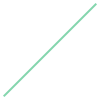

In [206]:
ls = shapely.geometry.LineString([(2,1),(3,2)])
ls

In [208]:
#shapely.geometry.MultiPoint(ls.coords)
list(ls.coords)

[(2.0, 1.0), (3.0, 2.0)]